### Prediccion de supervivencia en Titanic con una Red Neuronal

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [14]:
train_data = pd.read_csv("train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [15]:
train_labels = train_data['Survived']

In [16]:
columns_to_extract = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']

In [40]:
# Datos para entrenar el modelo
train_features = train_data[columns_to_extract]
train_features.head()

,Pclass,Sex,SibSp,Parch,Fare,Cabin,Embarked
0,3,male,1,0,7.2500,NaN,S
1,1,female,1,0,71.2833,C85,C
2,3,female,0,0,7.9250,NaN,S
3,1,female,1,0,53.1000,C123,S
4,3,male,0,0,8.0500,NaN,S


In [41]:
# One hot encoding, convierto los datos categoricos a numericos
# Class
train_features = pd.concat([train_features, pd.get_dummies(train_features['Pclass'], prefix='Pclass')], axis = 1)
train_features.drop(['Pclass'], axis = 1, inplace = True)

# Embarked
train_features = pd.concat([train_features, pd.get_dummies(train_features['Embarked'], prefix='Embarked')], axis = 1)
train_features.drop(['Embarked'], axis = 1, inplace = True)

# Sex
train_features = pd.concat([train_features, pd.get_dummies(train_features['Sex'], prefix='Sex')], axis = 1)
train_features.drop(['Sex'], axis = 1, inplace = True)

train_features

,SibSp,Parch,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
0,1,0,7.2500,NaN,0,0,1,0,0,1,0,1
1,1,0,71.2833,C85,1,0,0,1,0,0,1,0
2,0,0,7.9250,NaN,0,0,1,0,0,1,1,0
3,1,0,53.1000,C123,1,0,0,0,0,1,1,0
4,0,0,8.0500,NaN,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,13.0000,NaN,0,1,0,0,0,1,0,1
887,0,0,30.0000,B42,1,0,0,0,0,1,1,0
888,1,2,23.4500,NaN,0,0,1,0,0,1,1,0
889,0,0,30.0000,C148,1,0,0,1,0,0,0,1


In [42]:
train_features['Cabin1'] = train_features['Cabin'].astype(str).str[0] # extraigo primera letra del codigo de cabin
train_features['Cabin1'].unique()
# el n me molesta ya que se corresponde a NaN


array(['n', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [43]:
# Veo como se ditribuyen estas letras
train_features['Cabin1'].value_counts()

n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: Cabin1, dtype: int64

In [45]:
# para solucionar este valor de n podria aplicarle una distribucion de probabilidad,
# pero por simplicidad se tomara de valor el segundo que mas se repite en este caso la C
train_features['Cabin1'] = train_features['Cabin']

In [46]:
train_features

,SibSp,Parch,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Cabin1
0,1,0,7.2500,NaN,0,0,1,0,0,1,0,1,NaN
1,1,0,71.2833,C85,1,0,0,1,0,0,1,0,C85
2,0,0,7.9250,NaN,0,0,1,0,0,1,1,0,NaN
3,1,0,53.1000,C123,1,0,0,0,0,1,1,0,C123
4,0,0,8.0500,NaN,0,0,1,0,0,1,0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,13.0000,NaN,0,1,0,0,0,1,0,1,NaN
887,0,0,30.0000,B42,1,0,0,0,0,1,1,0,B42
888,1,2,23.4500,NaN,0,0,1,0,0,1,1,0,NaN
889,0,0,30.0000,C148,1,0,0,1,0,0,0,1,C148


In [47]:
train_features['Cabin'] = train_features['Cabin1'].fillna('C')
train_features

,SibSp,Parch,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Cabin1
0,1,0,7.2500,C,0,0,1,0,0,1,0,1,NaN
1,1,0,71.2833,C85,1,0,0,1,0,0,1,0,C85
2,0,0,7.9250,C,0,0,1,0,0,1,1,0,NaN
3,1,0,53.1000,C123,1,0,0,0,0,1,1,0,C123
4,0,0,8.0500,C,0,0,1,0,0,1,0,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,13.0000,C,0,1,0,0,0,1,0,1,NaN
887,0,0,30.0000,B42,1,0,0,0,0,1,1,0,B42
888,1,2,23.4500,C,0,0,1,0,0,1,1,0,NaN
889,0,0,30.0000,C148,1,0,0,1,0,0,0,1,C148


In [48]:
train_features['Cabin1'] = train_features['Cabin']
train_features

,SibSp,Parch,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Cabin1
0,1,0,7.2500,C,0,0,1,0,0,1,0,1,C
1,1,0,71.2833,C85,1,0,0,1,0,0,1,0,C85
2,0,0,7.9250,C,0,0,1,0,0,1,1,0,C
3,1,0,53.1000,C123,1,0,0,0,0,1,1,0,C123
4,0,0,8.0500,C,0,0,1,0,0,1,0,1,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,13.0000,C,0,1,0,0,0,1,0,1,C
887,0,0,30.0000,B42,1,0,0,0,0,1,1,0,B42
888,1,2,23.4500,C,0,0,1,0,0,1,1,0,C
889,0,0,30.0000,C148,1,0,0,1,0,0,0,1,C148


In [49]:
train_features['Cabin1'] = train_features['Cabin1'].astype(str).str[0]

In [50]:
train_features

,SibSp,Parch,Fare,Cabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Cabin1
0,1,0,7.2500,C,0,0,1,0,0,1,0,1,C
1,1,0,71.2833,C85,1,0,0,1,0,0,1,0,C
2,0,0,7.9250,C,0,0,1,0,0,1,1,0,C
3,1,0,53.1000,C123,1,0,0,0,0,1,1,0,C
4,0,0,8.0500,C,0,0,1,0,0,1,0,1,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,13.0000,C,0,1,0,0,0,1,0,1,C
887,0,0,30.0000,B42,1,0,0,0,0,1,1,0,B
888,1,2,23.4500,C,0,0,1,0,0,1,1,0,C
889,0,0,30.0000,C148,1,0,0,1,0,0,0,1,C


In [51]:
train_features = pd.concat([train_features, pd.get_dummies(train_features['Cabin1'], prefix='Cabin1')], axis = 1)
train_features.drop(['Cabin1'], axis = 1, inplace = True)
train_features.drop(['Cabin'], axis = 1, inplace = True)
train_features

,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Cabin1_A,Cabin1_B,Cabin1_C,Cabin1_D,Cabin1_E,Cabin1_F,Cabin1_G,Cabin1_T
0,1,0,7.2500,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0
1,1,0,71.2833,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0
2,0,0,7.9250,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0
3,1,0,53.1000,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0
4,0,0,8.0500,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,13.0000,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0
887,0,0,30.0000,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0
888,1,2,23.4500,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0
889,0,0,30.0000,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0


In [54]:
# Elimino la columna T porque solo posee un dato y es irrelevante para la prediccion
#train_features.drop(['Cabin1_T'], axis = 1, inplace = True)
train_features

,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Cabin1_A,Cabin1_B,Cabin1_C,Cabin1_D,Cabin1_E,Cabin1_F,Cabin1_G
0,1,0,7.2500,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0
1,1,0,71.2833,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0
2,0,0,7.9250,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0
3,1,0,53.1000,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0
4,0,0,8.0500,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,13.0000,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0
887,0,0,30.0000,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0
888,1,2,23.4500,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0
889,0,0,30.0000,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0


In [55]:
train_labels

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [56]:
# Pasamos a armar la red
model = tf.keras.Sequential([
    tf.keras.layers.Input([None, 18]),
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dropout(0, 2),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [57]:
# Optimizador y Funcion de Error
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.binary_crossentropy,
              metrics = ['accuracy'])

In [58]:
history = model.fit(train_features, train_labels, validation_split = 0.2, epochs = 100)

Epoch 1/100
23/23 [==============================] - 1s 12ms/step - loss: 0.8787 - accuracy: 0.5492 - val_loss: 0.8784 - val_accuracy: 0.6425
Epoch 2/100
23/23 [==============================] - 0s 4ms/step - loss: 0.6600 - accuracy: 0.6587 - val_loss: 0.4992 - val_accuracy: 0.7765
Epoch 3/100
23/23 [==============================] - 0s 4ms/step - loss: 0.6876 - accuracy: 0.6910 - val_loss: 0.5029 - val_accuracy: 0.7933
Epoch 4/100
23/23 [==============================] - 0s 3ms/step - loss: 0.6226 - accuracy: 0.7275 - val_loss: 0.4859 - val_accuracy: 0.7765
Epoch 5/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5398 - accuracy: 0.7458 - val_loss: 0.4741 - val_accuracy: 0.7989
Epoch 6/100
23/23 [==============================] - 0s 3ms/step - loss: 0.5187 - accuracy: 0.7893 - val_loss: 0.4319 - val_accuracy: 0.8268
Epoch 7/100
23/23 [==============================] - 0s 3ms/step - loss: 0.4841 - accuracy: 0.7893 - val_loss: 0.4526 - val_accuracy: 0.8212
Epoch 8/100


In [59]:
test_loss, test_acc = model.evaluate(train_features, train_labels, verbose = 2)

28/28 - 0s - loss: 0.3886 - accuracy: 0.8328 - 51ms/epoch - 2ms/step


In [60]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


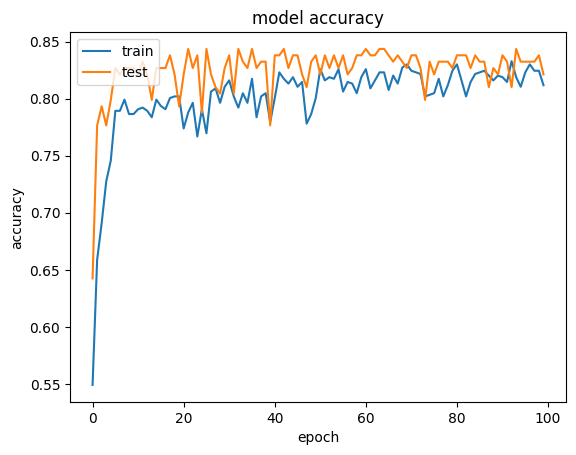

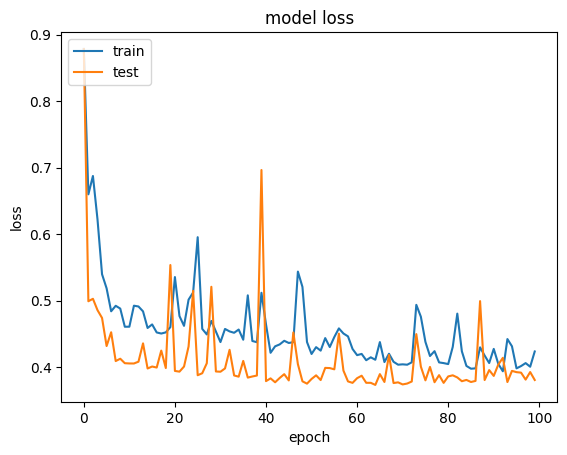

In [62]:
# Graficamos el comportamiento del entrenamiento
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()
# Summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [63]:
# Pasamos a realizar las predicciones con los datos de test.csv
test_data = pd.read_csv('test.csv')

In [64]:
columns_to_extract = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked']
test_features = test_data[columns_to_extract]

# Class
test_features = pd.concat([test_features, pd.get_dummies(test_features['Pclass'], prefix='Pclass')], axis = 1)
test_features.drop(['Pclass'], axis = 1, inplace = True)

# Embarked
test_features = pd.concat([test_features, pd.get_dummies(test_features['Embarked'], prefix='Embarked')], axis = 1)
test_features.drop(['Embarked'], axis = 1, inplace = True)

# Sex
test_features = pd.concat([test_features, pd.get_dummies(test_features['Sex'], prefix='Sex')], axis = 1)
test_features.drop(['Sex'], axis = 1, inplace = True)
test_features['Cabin1'] = test_features['Cabin']
test_features['Cabin'] = test_features['Cabin1'].fillna('C')
test_features['Cabin1'] = test_features['Cabin']
test_features['Cabin1'] = test_features['Cabin1'].astype(str).str[0]
test_features = pd.concat([test_features, pd.get_dummies(test_features['Cabin1'], prefix='Cabin1')], axis = 1)
test_features.drop(['Cabin1'], axis = 1, inplace = True)
test_features.drop(['Cabin'], axis = 1, inplace = True)

In [65]:
test_features

,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Cabin1_A,Cabin1_B,Cabin1_C,Cabin1_D,Cabin1_E,Cabin1_F,Cabin1_G
0,0,0,7.8292,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0
1,1,0,7.0000,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0
2,0,0,9.6875,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0
3,0,0,8.6625,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0
4,1,1,12.2875,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0,0,8.0500,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0
414,0,0,108.9000,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0
415,0,0,7.2500,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0
416,0,0,8.0500,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0


In [67]:
predictions = model.predict(test_features)
predictions

14/14 [==============================] - 0s 1ms/step


array([[3.92569862e-02],
       [6.79931700e-01],
       [2.26320680e-02],
       [1.24109358e-01],
       [5.73857784e-01],
       [1.26789927e-01],
       [7.90823996e-01],
       [2.53025323e-01],
       [6.87198699e-01],
       [1.16164207e-01],
       [1.19411483e-01],
       [2.62867630e-01],
       [9.95015919e-01],
       [1.53150961e-01],
       [9.93217587e-01],
       [9.75525200e-01],
       [4.39242274e-02],
       [1.59012452e-01],
       [5.96310258e-01],
       [6.87157929e-01],
       [1.93935260e-01],
       [7.48429969e-02],
       [9.02036488e-01],
       [2.40569726e-01],
       [9.95516002e-01],
       [1.18859112e-01],
       [9.90346611e-01],
       [1.59012452e-01],
       [4.57018554e-01],
       [2.40071416e-01],
       [1.53150991e-01],
       [1.75976545e-01],
       [4.31030035e-01],
       [4.44574445e-01],
       [1.95093915e-01],
       [1.59150138e-01],
       [4.36564296e-01],
       [4.24914360e-01],
       [1.28159150e-01],
       [3.38737577e-01],


In [68]:
# Redondeo los valores entre 0 y 1
out = predictions.round().astype(int)

<ipython-input-68-6470487deed3>:2: RuntimeWarning: invalid value encountered in cast
  out = predictions.round().astype(int)


In [69]:
out

array([[                   0],
       [                   1],
       [                   0],
       [                   0],
       [                   1],
       [                   0],
       [                   1],
       [                   0],
       [                   1],
       [                   0],
       [                   0],
       [                   0],
       [                   1],
       [                   0],
       [                   1],
       [                   1],
       [                   0],
       [                   0],
       [                   1],
       [                   1],
       [                   0],
       [                   0],
       [                   1],
       [                   0],
       [                   1],
       [                   0],
       [                   1],
       [                   0],
       [                   0],
       [                   0],
       [                   0],
       [                   0],
       [

In [71]:
submission_pd = test_data['PassengerId']
submission_pd

0       892
1       893
2       894
3       895
4       896
       ... 
413    1305
414    1306
415    1307
416    1308
417    1309
Name: PassengerId, Length: 418, dtype: int64

In [72]:
submission_pd = pd.concat([submission_pd, pd.DataFrame(data = out, columns = ['Survived'])], axis = 1)
submission_pd

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [73]:
submission_pd.to_csv('predictions_titanic.csv', index = False)